In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
from scipy.io import loadmat

get_dir = os.getcwd()
os.chdir(get_dir)

np.random.seed(1234)

In [2]:
def get_fvalues(x, y, nue):
    
    zeta = (0.5 / nue) - np.sqrt((1 / (4 * nue ** 2)) + 4 * np.pi ** 2)

    u_val = 1 - np.exp(zeta * x) * np.cos(2 * np.pi * y)
    v_val = (zeta / (2 * np.pi)) * np.exp(zeta * x) * np.sin(2 * np.pi * y)
    p_val = 0.5 * (1 - np.exp(2 * zeta * x))

    return u_val, v_val, p_val

def get_predictions(model, test_data):
    
    u_test, v_test, p_test = model.predict(test_data, batch_size=4096)
    return u_test, v_test, p_test
def get_repeated_tensors(x, y, u, v, p, num_samples):
    return (np.repeat(x.reshape((1, -1)), num_samples, axis=0), 
           np.repeat(y.reshape((1, -1)), num_samples, axis=0),
           np.repeat(u.reshape((1, -1)), num_samples, axis=0),
           np.repeat(v.reshape((1, -1)), num_samples, axis=0),
           np.repeat(p.reshape((1, -1)), num_samples, axis=0))

In [3]:
def get_true_test_values(model, nue, xlim, ylim, grid_size, seq_dir, TP=True):
    
    true_val = []
    pred_val = []
    u_val = {'true': [], 'pred': []}
    v_val = {'true': [], 'pred': []}
    
    xdisc = np.linspace(start=xlim[0], stop=xlim[1], num=grid_size)
    ydisc = np.linspace(start=ylim[0], stop=ylim[1], num=grid_size)
    
    X, Y = np.meshgrid(xdisc, ydisc)
    grid_loc = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    coord_val = pd.read_csv(seq_dir)
    x_seq, y_seq = coord_val['0'].values, coord_val['1'].values
    
    for i in nue:
        u_seq, v_seq, p_seq = get_fvalues(x_seq, y_seq, nue=i)
        xbc, ybc, ubc, vbc, pbc = get_repeated_tensors(x_seq, y_seq, u_seq, v_seq, p_seq, num_samples=len(grid_loc))
        if TP:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:], xbc, ybc, ubc, vbc, pbc]
        else:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:], ubc, vbc, pbc]
        
        u_test, v_test, p_test = get_predictions(model, test_data)
        
        u_test = u_test.reshape(X.shape)
        v_test = v_test.reshape(X.shape)
    
        u_true, v_true, p_true = get_fvalues(x=grid_loc[:, 0:1], y=grid_loc[:, 1:], nue=i)
        
        u_true = u_true.reshape(X.shape)
        v_true = v_true.reshape(X.shape)
        
        true_mag = (u_true ** 2 + v_true ** 2)**0.5
        pred_mag = (u_test ** 2 + v_test ** 2)**0.5
        
        true_val.append(true_mag)
        pred_val.append(pred_mag)
        
        u_val['true'].append(u_true)
        u_val['pred'].append(u_test)
        v_val['true'].append(v_true)
        v_val['pred'].append(v_test)
        
    return X, Y, true_val, pred_val, u_val, v_val

In [4]:
def get_plots(x, y, true_val, pred_val, u_val, v_val, grid_spec, plot_title, plot_save, 
              plot_dir, fig_size,shrink=1, dm=False, lxd = [0.5, 0.5],lyd=[0.1, 0.9], 
              lx=0.25, rx=0.75, text_y=0.9, clim=[0., 4.5], eclim = [0., 0.035], 
              lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
              dt=['Seen', 'Unseen'], cbar_kwargs=None, value=None):
    
    fig, ax = plt.subplots(3, len(true_val),figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    
    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    
    def fmt(x, pos):
        return f'{x:.1e}'
    level = np.linspace(clim[0], clim[1], num=10)
    err_level = np.linspace(eclim[0], eclim[1], num=10)
    
    for j in range(len(true_val)):
     
        pres = ax[0][j].streamplot(x, y, u_val['pred'][j], v_val['pred'][j], color='k', 
                                    linewidth=0.5)
        pre = ax[0][j].contourf(x, y, pred_val[j], level, cmap='rainbow')

        trus = ax[1][j].streamplot(x, y, u_val['true'][j], v_val['true'][j], color='k', 
                                    linewidth=0.5)
        ref = ax[1][j].contourf(x, y, true_val[j], level, cmap='rainbow')
        
        rel_err = np.log10(abs(true_val[j] - pred_val[j])/(1 + abs(true_val[j])))
        
        if dm:
            er = ax[2][j].contourf(x, y, rel_err, err_level, cmap='Blues', extend='both')
            er.cmap.set_under('orange')
            er.cmap.set_over('orange')
        else:
            er=ax[2][j].contourf(x, y, rel_err, err_level, cmap='Blues')
        
        ax[0][j].set_title(plot_title[0][j],fontsize=10, fontweight='bold')
        ax[0][j].set_xlim(xlim[0], xlim[1])
        ax[0][j].set_ylim(ylim[0], ylim[1])

        ax[1][j].set_xlim(xlim[0], xlim[1])
        ax[1][j].set_ylim(ylim[0], ylim[1])
        
        ax[2][j].set_xlabel('X', fontsize=10, fontweight='bold')

        for row in ax:
            row[j].set_aspect(value, adjustable='box')

    pcbar = fig.colorbar(pre, ax=ax[0, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    pcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    tcbar = fig.colorbar(ref, ax=ax[1, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    tcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    ecbar = fig.colorbar(er, ax = ax[2, :], **cbar_kwargs)
    ecbar.set_label('log$_{10}$(Relative Error)', fontsize=10, fontweight='bold')
    # ecbar.formatter = tick.FuncFormatter(fmt)
    # ecbar.update_ticks()
    
    ax[0][0].set_ylabel(lbs[0], fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(lbs[1], fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel(lbs[2], fontsize=10, fontweight='bold')

    fig.text(lx, text_y, dt[0], ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, text_y, dt[1], ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
    
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Figure_8: kovasznay Flow 

In [5]:
PINTO_model = keras.models.load_model('../Trained_models/KF_PINTO/KF_PINTO_model/')

train_test_nue = [1/20, 1/50, 1/15, 1/25]
xlim = [-0.5, 1.0]
ylim = [-0.5, 1.5]
grid_size = 64
seq_dir = '../Trained_models/KF_PINTO/seq_data.csv'

x, y, tno_true, tno_pred, tno_u_val, tno_v_val = get_true_test_values(
    model=PINTO_model, nue=train_test_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir)

1/1 [==============================] - 0s 23ms/step


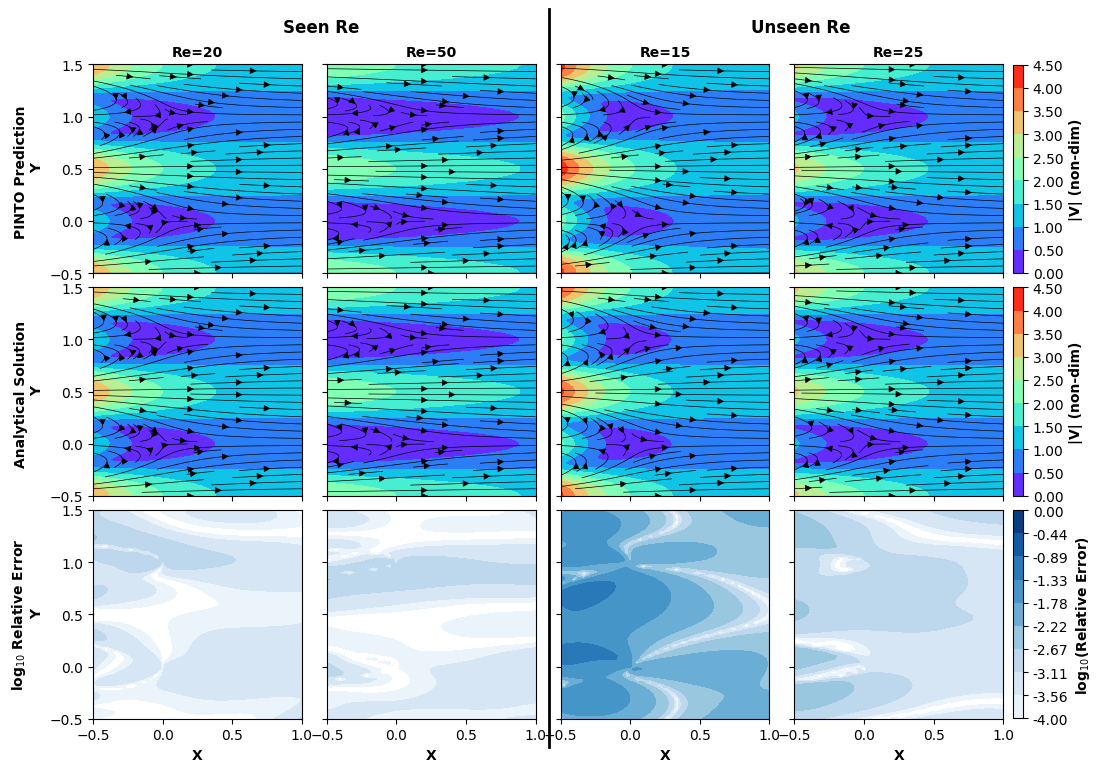

In [6]:
pdir = 'Figure_8.png'
pt = [['Re=20', 'Re=50', 'Re=15', 'Re=25']] # titles for each column
plt_save = True # saving the plot 
eclim = [-4, 0]  # error countour colorbar limits
clim = [0., 4.5] # prediction and true contour plots colorbar limits
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0.12, 'hspace': -0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=tno_true, pred_val=tno_pred, u_val=tno_u_val, v_val=tno_v_val, 
          plot_save=plt_save, grid_spec=grid_spec, plot_title=pt, plot_dir=pdir, fig_size=(12,9), shrink=1,
          lxd=[0.505, 0.505], lyd=[0.1, 0.92], lx=0.315, rx=0.715, text_y=0.9, clim=clim, eclim=eclim,
          lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'log$_{10}$ Relative Error \n Y'], 
	  dt=['Seen Re', 'Unseen Re'], cbar_kwargs=cbar_kwargs, value=1.5/2.)

## PI-DeepONet Plots

In [7]:
pid_model = keras.models.load_model('../Trained_models/KF_DeepONet/KF_Deeponet_model.keras')

seq_dir = '../Trained_models/KF_DeepONet/seq_data.csv'


x, y, pid_true, pid_pred, pid_u_val, pid_v_val = get_true_test_values(
    model=pid_model, nue=train_test_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 19ms/step


In [8]:
# pdir = 'PI_DeepONets_Kovasznay_training_testing_plots'
# pt = [['Re=20', 'Re=50', 'Re=15', 'Re=25']] # plot titles for each column
# plt_save = False # saving the plot
# eclim = [-4, 0]  # error countour colorbar limits
# clim = [0., 4.5] # prediction and true contour plots colorbar limits
# cbar_kwargs = {
#         'fraction': 0.0112, 
#         'pad': 0.01,
#         'format': tick.FormatStrFormatter('%.2f')
#     }

# grid_spec = {'wspace': 0.11, 'hspace': 0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
# get_plots(x,  y, true_val=pid_true, pred_val=pid_pred, u_val=pid_u_val, v_val=pid_v_val, 
#           plot_save=plt_save, grid_spec=grid_spec, plot_title=pt, plot_dir=pdir, fig_size=(10,8), shrink=1, dm=True,
#           lxd=[0.512, 0.512], lyd=[0.1, 0.92], lx=0.315, rx=0.715, text_y=0.92, clim=clim, eclim=eclim,
#           lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
# 	  dt=['Seen Re', 'Unseen Re'], cbar_kwargs=cbar_kwargs, value=1.5/2.)

## Table1: Performance metrics

In [9]:
training_nue = [1/20, 1/30, 1/50, 1/80]
testing_nue = 1/np.random.uniform(low=10., high=100., size=[1, 20]).reshape(-1)

In [10]:
def get_metrics(true_val, pred_val):
    rel_err = abs(np.concatenate(true_val, axis=0) - np.concatenate(pred_val, axis=0))/(1 + abs(np.concatenate(true_val)))
    mean_metric = np.mean(rel_err)
    std_metric = np.std(rel_err)
    
    return mean_metric, std_metric


In [11]:
sens_dir = '../Trained_models/KF_PINTO/seq_data.csv'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values(
    model=PINTO_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir)

_, _, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir)

1/1 [==============================] - 0s 23ms/step


In [12]:
sens_dir = '../Trained_models/KF_DeepONet/seq_data.csv'

_, _, pid_train_true, pid_train_pred, pid_tr_u_val, pid_tr_v_val = get_true_test_values(
    model=pid_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir, TP=False)

_, _, pid_test_true, pid_test_pred, pid_ts_u_val, pid_ts_v_val = get_true_test_values(
    model=pid_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [13]:
print("PINTO Metrics")

train_mean_metric, train_std_metric = get_metrics(tno_train_true, tno_train_pred)
test_mean_metric, test_std_metric = get_metrics(tno_test_true, tno_test_pred)

print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PINTO Metrics
mean relative error across all training sets is:  0.0003769709075962345
std of relative error across training sets is:  0.0003254655183820042
mean relative error across all testing sets is:  0.00410304332121564
std of relative error across testing sets is:  0.02548550447365421


In [14]:
print("PI-DeepONets Metrics")

train_mean_metric, train_std_metric = get_metrics(pid_train_true, pid_train_pred)
test_mean_metric, test_std_metric = get_metrics(pid_test_true, pid_test_pred)

print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PI-DeepONets Metrics
mean relative error across all training sets is:  0.000804964248250152
std of relative error across training sets is:  0.0006673132236095457
mean relative error across all testing sets is:  0.02257629995488104
std of relative error across testing sets is:  0.06547687953077821


## Appendix A: Performance metrics

In [15]:
def get_metrics_TableA3(train_true_val, test_true_val,  train_pred_val, test_pred_val, index):
    
    RMSE = np.sqrt(np.mean((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))**2))
    nRMSE = RMSE/np.sqrt(np.mean(np.concatenate(train_pred_val, axis=0)**2))
    MAE = np.mean(abs((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))))
    RMAE = MAE/np.mean(abs(np.concatenate(train_true_val, axis=0)))
    
    tsRMSE = np.sqrt(np.mean((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))**2))
    tsnRMSE = RMSE/np.sqrt(np.mean(np.concatenate(test_pred_val, axis=0)**2))
    tsMAE = np.mean(abs((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))))
    tsRMAE = MAE/np.mean(abs(np.concatenate(test_true_val, axis=0)))
    

    return pd.DataFrame({'train_RMSE': [RMSE], 'train_MAE': [MAE], 
                         'test_RMSE': [tsRMSE], 'test_MAE': [tsMAE]}, index=index)


In [16]:
training_nue = [1/20, 1/30, 1/50, 1/80]
testing_nue = 1/np.random.uniform(low=15., high=100., size=[1, 20]).reshape(-1)

sens_dir = '../Trained_models/KF_PINTO/seq_data.csv'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values(
    model=PINTO_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir)

_, _, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir)

sens_dir = '../Trained_models/KF_DeepONet/seq_data.csv'

_, _, pid_train_true, pid_train_pred, pid_tr_u_val, pid_tr_v_val = get_true_test_values(
    model=pid_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir, TP=False)

_, _, pid_test_true, pid_test_pred, pid_ts_u_val, pid_ts_v_val = get_true_test_values(
    model=pid_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 19ms/step


In [17]:
get_metrics_TableA3(train_true_val=tno_train_true, test_true_val=tno_test_true, train_pred_val=tno_train_pred, 
                    test_pred_val=tno_test_pred, index=['PINTO'])

,train_RMSE,train_MAE,test_RMSE,test_MAE
PINTO,0.000913,0.000708,0.001351,0.001002


In [18]:
get_metrics_TableA3(train_true_val=pid_train_true, test_true_val=pid_test_true, train_pred_val=pid_train_pred, 
                    test_pred_val=pid_test_pred, index=['PI-DeepONets'])

,train_RMSE,train_MAE,test_RMSE,test_MAE
PI-DeepONets,0.002219,0.001618,0.04349,0.026917


In [19]:
def get_metrics_TableA4(train_true_val, test_true_val,  train_pred_val, test_pred_val, index):
    
    RMSE = np.sqrt(np.mean((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))**2))
    nRMSE = RMSE/np.sqrt(np.mean(np.concatenate(train_pred_val, axis=0)**2))
    MAE = np.mean(abs((np.concatenate(train_true_val, axis=0) - np.concatenate(train_pred_val, axis=0))))
    RMAE = MAE/np.mean(abs(np.concatenate(train_true_val, axis=0)))
    
    tsRMSE = np.sqrt(np.mean((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))**2))
    tsnRMSE = RMSE/np.sqrt(np.mean(np.concatenate(test_pred_val, axis=0)**2))
    tsMAE = np.mean(abs((np.concatenate(test_true_val, axis=0) - np.concatenate(test_pred_val, axis=0))))
    tsRMAE = MAE/np.mean(abs(np.concatenate(test_true_val, axis=0)))
    

    return pd.DataFrame({'train_nRMSE': [nRMSE], 'train_RMAE': [RMAE], 
                         'test_nRMSE': [tsnRMSE], 'test_RMAE': [tsRMAE]}, index=index)

In [20]:
training_nue = [1/20, 1/30, 1/50, 1/80]
testing_nue = 1/np.random.uniform(low=10., high=100., size=[1, 20]).reshape(-1)

sens_dir = '../Trained_models/KF_PINTO/seq_data.csv'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values(
    model=PINTO_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir)

_, _, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir)

sens_dir = '../Trained_models/KF_DeepONet/seq_data.csv'

_, _, pid_train_true, pid_train_pred, pid_tr_u_val, pid_tr_v_val = get_true_test_values(
    model=pid_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir, TP=False)

_, _, pid_test_true, pid_test_pred, pid_ts_u_val, pid_ts_v_val = get_true_test_values(
    model=pid_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 20ms/step


In [21]:
get_metrics_TableA4(train_true_val=tno_train_true, test_true_val=tno_test_true, train_pred_val=tno_train_pred, 
                    test_pred_val=tno_test_pred, index=['PINTO'])

,train_nRMSE,train_RMAE,test_nRMSE,test_RMAE
PINTO,0.000739,0.000662,0.000715,0.000655


In [22]:
get_metrics_TableA4(train_true_val=pid_train_true, test_true_val=pid_test_true, train_pred_val=pid_train_pred, 
                    test_pred_val=pid_test_pred, index=['PI-DeepONets'])

,train_nRMSE,train_RMAE,test_nRMSE,test_RMAE
PI-DeepONets,0.001795,0.001513,0.001758,0.001497


## Analysis with Re 

In [23]:
testing_nue = 1/np.linspace(15., 300., 50).reshape(-1)

xlim = [-0.5, 1.0]
ylim = [-0.5, 1.5]
grid_size = 64
seq_dir = '../Trained_models/KF_PINTO/seq_data.csv'

x, y, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir)

1/1 [==============================] - 0s 23ms/step


In [24]:
rel_err = (abs(np.concatenate(tno_test_true, axis=0) - np.concatenate(tno_test_pred, axis=0))/(1 + abs(np.concatenate(tno_test_true)))).reshape(-1, 64, 64)
re_df = pd.DataFrame({'testing_Re': 1/testing_nue, 'rel_er': np.mean(rel_err.reshape(50, -1), axis=-1)})
re_df.to_csv('Relative_error_vs_Re.csv')

## Appendix C: Computational Time 

In [23]:
xdisc = np.linspace(0, 1, 256)
ydisc = np.linspace(0, 1, 256)
X, Y = np.meshgrid(xdisc, ydisc)
xin = X.reshape((-1, 1))
yin  = Y.reshape((-1, 1))
x_sen = np.random.rand(len(xin), 80)
y_sen = np.random.rand(len(xin), 80)
u_sen = np.random.rand(len(xin), 80)
v_sen = np.random.rand(len(xin), 80)
p_sen = np.random.rand(len(xin), 80)

_ = PINTO_model.predict([xin, yin , x_sen, y_sen, u_sen, v_sen, p_sen], batch_size=256*256, verbose=0)
for i in range(10):
    _ = PINTO_model.predict([xin, yin , x_sen, y_sen, u_sen, v_sen, p_sen], batch_size=256*256)

1/1 [==============================] - 0s 168ms/step
